In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURATION ---
# Change this path to point to the specific run you want to analyze (e.g., 70M or 160M)
DETAILS_CSV = "wikipedia/experiments/run_20251223_222905/results/canary_details_full.csv" 
#TODO CAMBIARE
ORIGINAL_CANARIES_CSV = "memorization/canaries.csv" 

# Plotting style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

In [129]:
def load_data(details_path, meta_path):
    if not os.path.exists(details_path) or not os.path.exists(meta_path):
        print(f"❌ ERROR: Files not found at:\n{details_path}\n{meta_path}")
        return None

    print("✅ Loading files...")
    df_details = pd.read_csv(details_path)
    df_meta = pd.read_csv(meta_path)

    # Merge to get 'type' column (High/Low Entropy)
    # We merge on 'canary_id'
    df_merged = pd.merge(df_details, df_meta[['canary_id', 'type']], on='canary_id', how='left')
    
    # Check if exact_match exists
    if 'exact_match' not in df_merged.columns:
        print("⚠️ WARNING: 'exact_match' column not found. Filling with 0.")
        df_merged['exact_match'] = 0

    print(f"Merged Data Ready: {len(df_merged)} rows.")
    return df_merged

# Execute Load
df_data = load_data(DETAILS_CSV, ORIGINAL_CANARIES_CSV)
df_data.head()

✅ Loading files...
Merged Data Ready: 1200 rows.


,epoch,canary_id,global_loss_tgt,suffix_loss_tgt,exact_match,split,suffix_loss_ref,global_loss_ref,loss_optimum,mia_score,counterfactual_score,contextual_score,type
0,0,le_073aa1,5.830676,4.683833,0,validation,4.758480,5.928182,4.758480,0.074647,0.015687,0.015687,low_entropy
1,0,he_3c82e8,3.953699,4.673273,0,train,5.054495,5.834436,5.054495,0.381222,0.075422,0.075422,high_entropy
2,0,he_b6c479,3.619510,4.328096,0,train,5.462328,6.074971,5.462328,1.134232,0.207646,0.207646,high_entropy
3,0,le_30e20c,4.881455,4.467763,0,validation,4.104156,4.649610,4.104156,-0.363607,0.000000,0.000000,low_entropy
4,0,he_fa06a9,4.301926,5.208607,0,train,6.164864,6.834771,6.164864,0.956257,0.155114,0.155114,high_entropy


In [130]:
def calculate_dynamic_threshold(scores, fpr_target=0.10):
    """
    Calculates the threshold at the (1-FPR) percentile of the validation scores.
    """
    if len(scores) == 0: return float('inf')
    return np.percentile(scores, (1 - fpr_target) * 100)

def analyze_subset_metrics(df_subset):
    stats = []
    epochs = sorted(df_subset['epoch'].unique())
    
    for epoch in epochs:
        df_epoch = df_subset[df_subset['epoch'] == epoch]
        
        # 1. Split Data
        val_data = df_epoch[df_epoch['split'] == 'validation']
        train_data = df_epoch[df_epoch['split'] == 'train']
        
        # Skip if missing data
        if len(val_data) == 0 or len(train_data) == 0: 
            continue
            
        # 2. Calibrate MIA Threshold using VALIDATION set (Non-members)
        # We want 10% False Positive Rate on non-members
        tau = calculate_dynamic_threshold(val_data['mia_score'].values, fpr_target=0.10)
        
        # 3. Calculate Metrics on TRAINING set (Members)
        
        # A. MIA Recall
        is_memorized = train_data['mia_score'] > tau
        mia_recall = is_memorized.sum() / len(train_data)
        
        # B. Contextual & Counterfactual (Averages)
        avg_ctx = train_data['contextual_score'].mean()
        avg_cf = train_data['counterfactual_score'].mean()
        
        # C. Exact Match (Biderman / Extractability)
        # This is the percentage of training canaries generated verbatim
        if 'exact_match' in train_data.columns:
            extractability = train_data['exact_match'].mean()
        else:
            extractability = 0.0
        
        stats.append({
            'epoch': epoch, 
            'mia_recall': mia_recall, 
            'contextual_score': avg_ctx, 
            'counterfactual_score': avg_cf,
            'extractability': extractability
        })
        
    return pd.DataFrame(stats)

In [131]:
def plot_comparison(df_stats, title):
    if df_stats.empty:
        print(f"⚠️ No data to plot for {title}")
        return

    plt.figure(figsize=(12, 7))
    
    # 1. MIA Recall (Red)
    sns.lineplot(data=df_stats, x='epoch', y='mia_recall', label='MIA Recall', 
                 linewidth=2, color='crimson', alpha=0.6)
    
    # 2. Counterfactual (Green)
    sns.lineplot(data=df_stats, x='epoch', y='counterfactual_score', label='Counterfactual', 
                 linewidth=2, linestyle='-.', color='green', alpha=0.6)
    
    # 3. Contextual (Blue - Your Main Metric)
    sns.lineplot(data=df_stats, x='epoch', y='contextual_score', label='Contextual', 
                 linewidth=3, marker='s', color='royalblue')
    

    plt.title(title, fontsize=18, fontweight='bold', pad=15)
    plt.xlabel("Training Epochs", fontsize=14)
    plt.ylabel("Score (0.0 - 1.0)", fontsize=14)
    
    # Set limits slightly wider to see points clearly
    plt.ylim(-0.05, 1.05)
    plt.xticks(df_stats['epoch'].unique())
    
    plt.legend(loc='center right', fontsize=12, frameon=True, shadow=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

--- Analyzing High Entropy Canaries ---


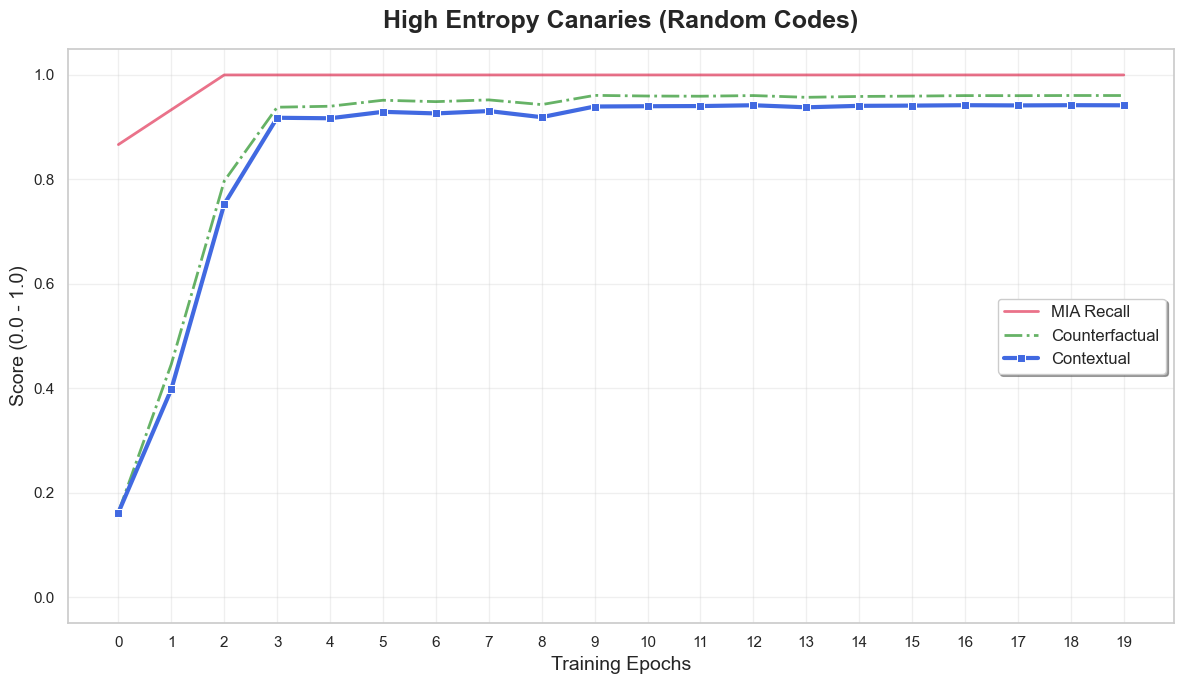

    epoch  mia_recall  contextual_score  counterfactual_score  extractability
19     19         1.0          0.941872              0.960587             0.0




In [133]:
if df_data is not None:
    # --- ANALYSIS 1: HIGH ENTROPY (Random Codes) ---
    print("--- Analyzing High Entropy Canaries ---")
    df_high = df_data[df_data['type'] == 'high_entropy']
    
    if not df_high.empty:
        stats_high = analyze_subset_metrics(df_high)
        plot_comparison(stats_high, "High Entropy Canaries (Random Codes)")
        # Optional: Print last epoch stats
        print(stats_high.tail(1))
    else:
        print("No High Entropy data found.")

    print("\n" + "="*50 + "\n")



--- Analyzing Low Entropy Canaries ---


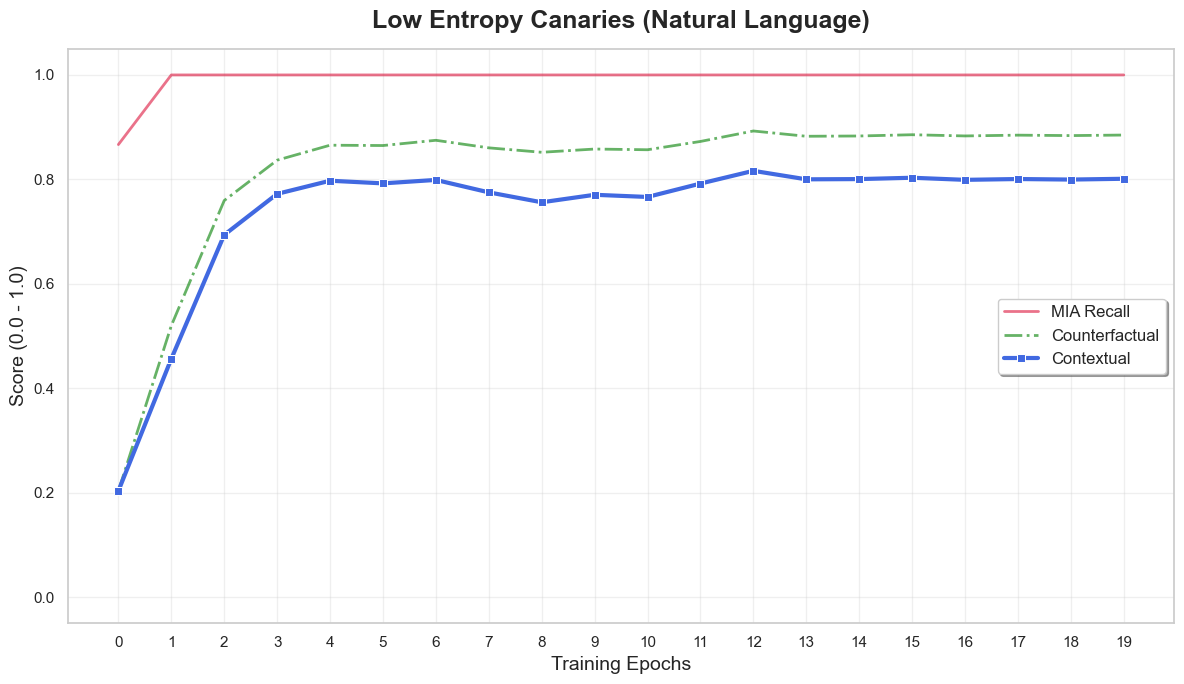

    epoch  mia_recall  contextual_score  counterfactual_score  extractability
19     19         1.0          0.801172              0.884912             0.0


In [134]:
# --- ANALYSIS 2: LOW ENTROPY (Natural Language) ---
print("--- Analyzing Low Entropy Canaries ---")
df_low = df_data[df_data['type'] == 'low_entropy']

if not df_low.empty:
    stats_low = analyze_subset_metrics(df_low)
    plot_comparison(stats_low, "Low Entropy Canaries (Natural Language)")
    # Optional: Print last epoch stats
    print(stats_low.tail(1))
else:
    print("No Low Entropy data found.")

--- Visualizzazione Exact Match: High Entropy ---


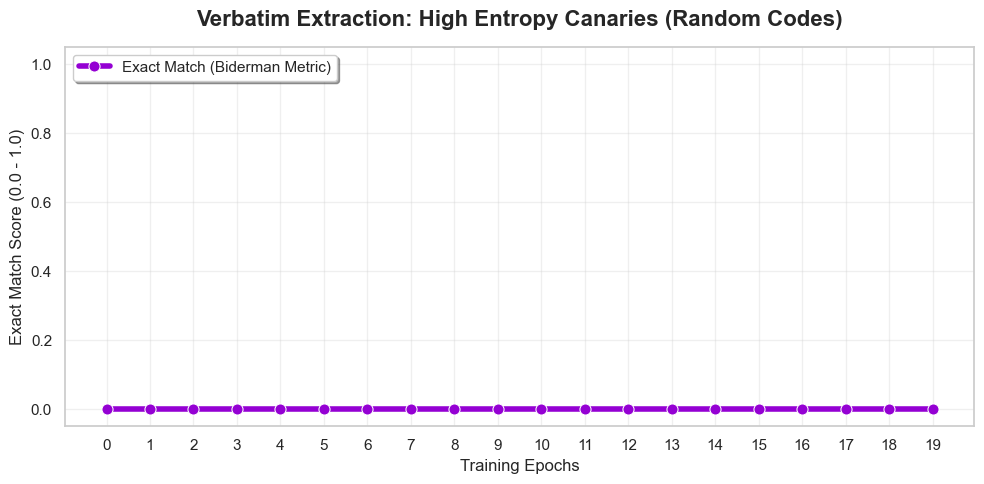

--- Visualizzazione Exact Match: Low Entropy ---


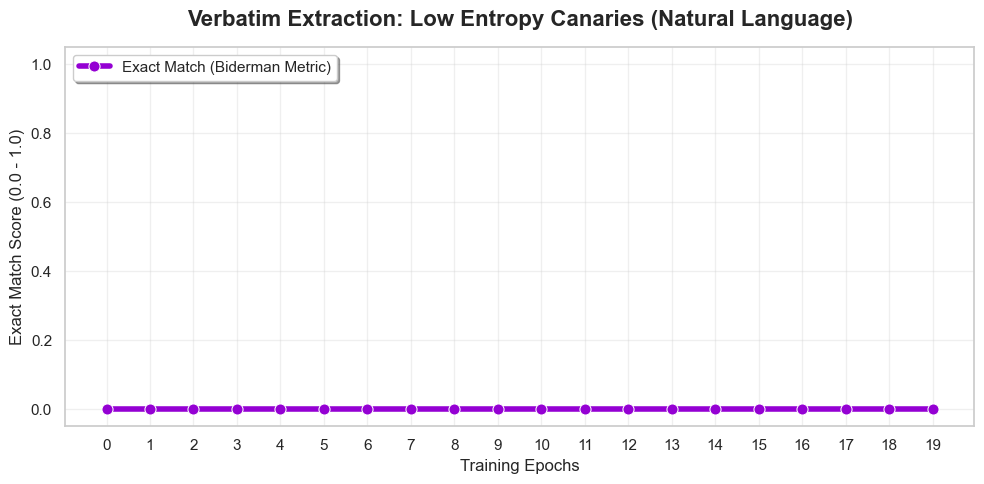

In [135]:
# --- NUOVO BLOCCO: SOLO EXACT MATCH ANALYSIS ---

def plot_exact_match_only(df_stats, title):
    """
    Plotta esclusivamente la metrica di Exact Match (Biderman).
    """
    if df_stats.empty:
        print(f"⚠️ No data to plot for {title}")
        return

    plt.figure(figsize=(10, 5))

    # Plot dell'Exact Match (chiamato 'extractability' nel DataFrame stats)
    sns.lineplot(
        data=df_stats,
        x='epoch',
        y='extractability',
        label='Exact Match (Biderman Metric)',
        linewidth=4,
        marker='o',
        markersize=8,
        color='darkviolet'  # Viola richiesto
    )

    plt.title(f"Verbatim Extraction: {title}", fontsize=16, fontweight='bold', pad=15)
    plt.xlabel("Training Epochs", fontsize=12)
    plt.ylabel("Exact Match Score (0.0 - 1.0)", fontsize=12)

    # Range fisso 0-1
    plt.ylim(-0.05, 1.05)
    plt.xticks(df_stats['epoch'].unique())

    plt.legend(loc='upper left', frameon=True, shadow=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# --- ESECUZIONE ---
if 'stats_high' in locals() and not stats_high.empty:
    print("--- Visualizzazione Exact Match: High Entropy ---")
    plot_exact_match_only(stats_high, "High Entropy Canaries (Random Codes)")

if 'stats_low' in locals() and not stats_low.empty:
    print("--- Visualizzazione Exact Match: Low Entropy ---")
    plot_exact_match_only(stats_low, "Low Entropy Canaries (Natural Language)")

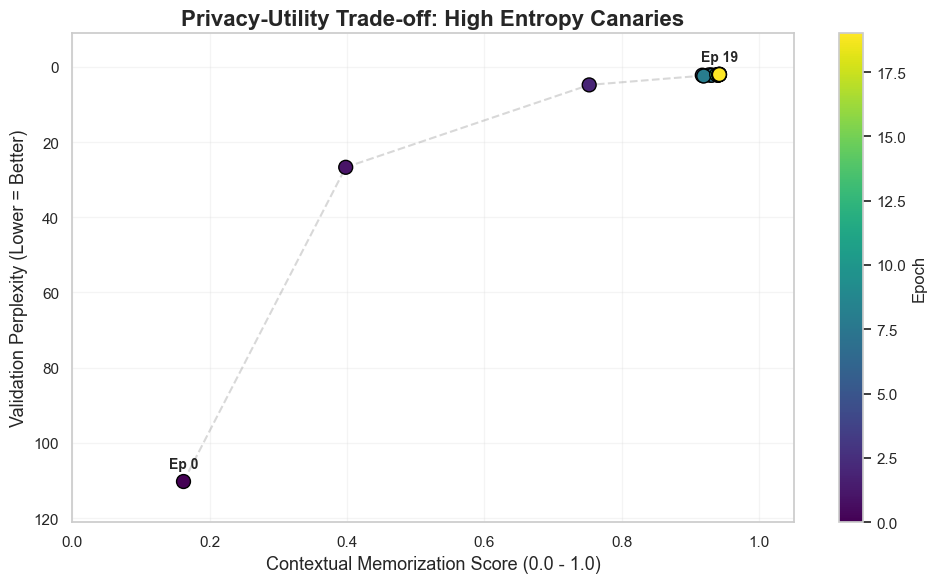

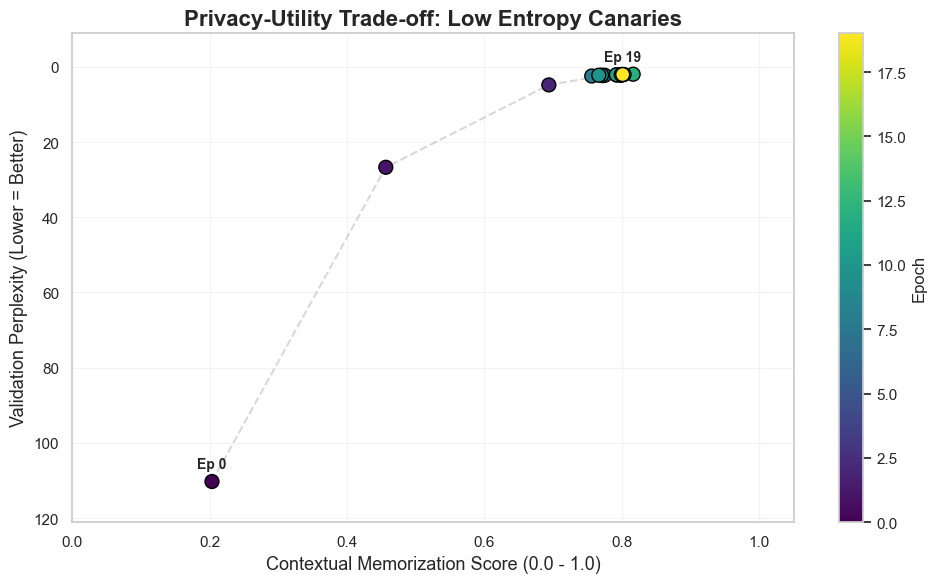

In [136]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. DEFINIZIONE FUNZIONE DI CARICAMENTO ---
def load_summary_metrics(path):
    """
    Carica il file metrics_summary.csv che contiene la perplexity per epoca.
    """
    if not os.path.exists(path):
        print(f"❌ ERROR: Summary file not found at: {path}")
        return None
    
    df_summary = pd.read_csv(path)
    
    # Verifichiamo il nome della colonna (tu hai indicato 'avg_perplexity')
    if 'avg_perplexity' not in df_summary.columns:
        print(f"⚠️ Warning: 'avg_perplexity' not found. Columns available: {df_summary.columns.tolist()}")
        return None
        
    return df_summary[['epoch', 'avg_perplexity']]

# --- 2. CONFIGURAZIONE PERCORSI E CARICAMENTO ---
# RESULTS_DIR è la cartella dove si trova canary_details_full.csv
RESULTS_DIR = os.path.dirname(DETAILS_CSV)
SUMMARY_PATH = os.path.join(RESULTS_DIR, "metrics_summary.csv")

# Carichiamo i dati della perplexity globale
df_summary_ppl = load_summary_metrics(SUMMARY_PATH)

# --- 3. DEFINIZIONE FUNZIONI DI PLOTTING ---
def get_global_limits(df_high_stats, df_low_stats, df_ppl):
    """
    Calcola i limiti comuni per rendere i grafici confrontabili.
    """
    # Asse X: sempre 0-1 per la memorizzazione
    x_lim = (0.0, 1.05) 
    
    # Asse Y: calcoliamo il range della perplexity
    if df_ppl is not None:
        y_min = df_ppl['avg_perplexity'].min()
        y_max = df_ppl['avg_perplexity'].max()
        margin = (y_max - y_min) * 0.1 # Margine del 10%
        y_lim = (y_min - margin, y_max + margin)
    else:
        y_lim = (None, None)
    return x_lim, y_lim

def plot_perplexity_vs_memorization(df_stats, df_ppl, title, x_lim, y_lim):
    if df_stats.empty or df_ppl is None:
        print(f"⚠️ Skipping {title}: Missing data.")
        return

    # Uniamo i dati delle canaries con la perplexity per epoca
    df_plot = pd.merge(df_stats, df_ppl, on='epoch')

    plt.figure(figsize=(10, 6))
    
    # Traiettoria
    plt.plot(df_plot['contextual_score'], df_plot['avg_perplexity'], 
             color='gray', linestyle='--', alpha=0.3)
    
    # Punti colorati per epoca
    scatter = plt.scatter(df_plot['contextual_score'], df_plot['avg_perplexity'], 
                          c=df_plot['epoch'], cmap='viridis', s=100, 
                          edgecolor='black', zorder=5)
    
    # Annotazioni Epoca 0 e Ultima
    for i, txt in enumerate(df_plot['epoch']):
        if i == 0 or i == len(df_plot)-1:
            plt.annotate(f"Ep {txt}", (df_plot['contextual_score'].iloc[i], df_plot['avg_perplexity'].iloc[i]), 
                         textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, fontweight='bold')

    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.gca().invert_yaxis() # Più bassa è la PPL, più è "in alto" l'utilità nel grafico

    plt.title(f"Privacy-Utility Trade-off: {title}", fontsize=16, fontweight='bold')
    plt.xlabel("Contextual Memorization Score (0.0 - 1.0)", fontsize=13)
    plt.ylabel("Validation Perplexity (Lower = Better)", fontsize=13)
    
    plt.colorbar(scatter, label='Epoch')
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

# --- 4. ESECUZIONE ---
if df_summary_ppl is not None:
    # Calcoliamo i limiti globali basandoci su stats_high e stats_low caricate in precedenza
    # Nota: Assicurati di aver già eseguito le celle che generano stats_high e stats_low
    global_x_lim, global_y_lim = get_global_limits(stats_high, stats_low, df_summary_ppl)

    if not stats_high.empty:
        plot_perplexity_vs_memorization(stats_high, df_summary_ppl, "High Entropy Canaries", global_x_lim, global_y_lim)
        
    if not stats_low.empty:
        plot_perplexity_vs_memorization(stats_low, df_summary_ppl, "Low Entropy Canaries", global_x_lim, global_y_lim)